<a href="https://colab.research.google.com/github/thashmadech/is417-project/blob/main/Sentiment_Analysis_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install swifter
#pip install --upgrade pyspark
#pip install swifter
#pip install --upgrade vaderSentiment
# pip install --upgrade textblob


     |████████████████████████████████| 296 kB 14.0 MB/s 
     |████████████████████████████████| 132 kB 58.4 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
import pandas as pd
import numpy as np
import dask
import re, string, unicodedata
from gensim.parsing.preprocessing import remove_stopwords
import nltk
from nltk import ngrams, word_tokenize, sent_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
from tqdm import tqdm
import random 
from textblob import TextBlob
import swifter
from sklearn.feature_extraction.text import CountVectorizer

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt



In [ ]:
# p = 0.5
# df_tweets = pd.read_csv('/content/drive/MyDrive/is417-project/Bitcoin_tweets.csv',engine='python',encoding='utf-8', error_bad_lines=False, dtype='str',          skiprows=lambda i: i>0 and random.random() > p)
df_tweets = pd.read_csv('/content/drive/MyDrive/is417-project/Bitcoin_tweets.csv',engine='python',encoding='utf-8', error_bad_lines=False)

In [ ]:
df_tweets.head()

user_name  ... is_retweet
0                             DeSota Wilson  ...      False
1                                  CryptoND  ...      False
2                                 Tdlmatias  ...      False
3                      Crypto is the future  ...      False
4  Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader  ...      False

[5 rows x 13 columns]

In [ ]:
df_tweets.shape

(1232809, 13)

In [ ]:
#df_tweets.info()

In [ ]:
#df_tweets[df_tweets['date']=="['ETH', 'BTC', 'Bitcoin']"]

In [ ]:
# for x in tqdm(df_tweets['date']):
#   try:
#     pd.to_datetime(x)
#   except:
#     print(x)

In [ ]:

# def datetime_checker(x):
#     try:
#       return pd.to_datetime(x, errors='coerce')
#     except:
#       return x


# df_tweets['datetime'] = df_tweets['date'].swifter.apply(datetime_checker)


In [ ]:

df_tweets['datetime'] = pd.to_datetime(df_tweets['date'], errors = 'coerce')


In [ ]:
import swifter
def is_datetime(x):
    try:
      pd.to_datetime(x)
      return True
    except:
      return False

df_tweets['is_datetime'] = df_tweets['date'].swifter.apply(is_datetime)

Pandas Apply:   0%|          | 0/1232809 [00:00<?, ?it/s]

In [ ]:
df_tweets = df_tweets[df_tweets.is_datetime != False]

In [ ]:
# df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232803 entries, 0 to 1232808
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_name         1232778 non-null  object        
 1   user_location     647832 non-null   object        
 2   user_description  1088175 non-null  object        
 3   user_created      1232801 non-null  object        
 4   user_followers    1232799 non-null  object        
 5   user_friends      1232799 non-null  object        
 6   user_favourites   1232799 non-null  object        
 7   user_verified     1232799 non-null  object        
 8   date              1232799 non-null  object        
 9   text              1232799 non-null  object        
 10  hashtags          1215994 non-null  object        
 11  source            1229435 non-null  object        
 12  is_retweet        1232749 non-null  object        
 13  datetime          1232799 non-null  dateti

In [ ]:
#df_tweets['datetime'].describe(datetime_is_numeric=True)

In [ ]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
df_tweets['text'].replace({'https': '<br>'}, regex=True)

0          Blue Ridge Bank shares halted by NYSE after #b...
1          😎 Today, that's this #Thursday, we will do a "...
2          Guys evening, I have read this article about B...
3          $BTC A big chance in a billion! Price: \487264...
4          This network is secured by 9 508 nodes as of t...
                                 ...                        
1232804    @SpeedUpBSC @debi_pada @AdaTiers @golf_grinder...
1232805    This time, what will happen between the US SEC...
1232806                          One #btc is only 205 #EGLD.
1232807    Want to join a group that posted TSLA 745P day...
1232808    cabanacrypto is live! @CabanaCrypto\n\n"HEX Ha...
Name: text, Length: 1232803, dtype: object

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
def preprocess_text(text_data, stopwords):

    # tqdm is for printing the status bar
    preprocessed_text = []

    for sentence in tqdm(text_data):

        if sentence is None:
          preprocessed_text.append("")
        else:
          sent = decontracted(sentence)
          sent = sent.replace('\\r', ' ')
          sent = sent.replace('\\n', ' ')
          sent = sent.replace('\\"', ' ')
          sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
          sent = re.sub(r'\W*\b\w{1,2}\b', '', sent)
          sent = re.sub('https?:\/\/\S+', '', sent)
          sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
          preprocessed_text.append(sent.lower().strip())
    
    return preprocessed_text

In [ ]:
preprocessed_text = preprocess_text(df_tweets['text'].values, stopwords)

100%|██████████| 1232803/1232803 [02:14<00:00, 9186.25it/s]


In [ ]:
#len(preprocessed_text)

1232803

In [ ]:
def cleanse_sentence(sentence):

  test = sentence.split()

  try:
    last = test[-1]
    test.remove(last)
    val = test.index('https')
    words = [test[val], test[val+1], test[val+2]]
  except:
    return sentence.replace("https", "")
  
  test.remove(words[0])
  test.remove(words[1])
  test.remove(words[2])

  return " ".join(test)


def cleanse_last(x):
  try:
    val = x.split()
    rep = val[-1]
    val.remove(rep)
  except:
    return x

  return " ".join(val)

preprocessed_text = list(map(cleanse_sentence, preprocessed_text))
preprocessed_text = list(map(cleanse_last, preprocessed_text))
df_tweets['text'] = preprocessed_text


In [ ]:
 
# df_first_half = df_tweets.sort_values('datetime',ascending=True).head(int(df_tweets.shape[0]*.5))
# df_second_half = df_tweets.sort_values('datetime',ascending=False).head(int(df_tweets.shape[0]*.5))


     |████████████████████████████████| 125 kB 11.9 MB/s 


     |████████████████████████████████| 636 kB 14.8 MB/s 
  Attempting uninstall: textblob
    Found existing installation: textblob 0.15.3
    Uninstalling textblob-0.15.3:
      Successfully uninstalled textblob-0.15.3


In [ ]:
def getSubjectivity(twt):
  try:
    return TextBlob(twt).sentiment.subjectivity
  except:
    return twt
   

def getPolarity(twt):
  return TextBlob(twt).sentiment.polarity


# df_tweets['Subjectivity'] = df_tweets['text'].swifter.apply(lambda x: getSubjectivity(x))



In [ ]:
df_tweets['Polarity'] = df_tweets['text'].swifter.apply(lambda x: getPolarity(x))


Pandas Apply:   0%|          | 0/1232803 [00:00<?, ?it/s]

In [ ]:
mel_count=df_tweets['source'].str.contains('bot').sum()

mel_count

TypeError: ignored

In [ ]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
df_tweets['text_token'] = df_tweets['text'].swifter.apply(tokenizer.tokenize)



Pandas Apply:   0%|          | 0/1232803 [00:00<?, ?it/s]

In [ ]:
df_tweets['text_token'].sample(10)


1185683    [remipromotes, cryptomolah, pump, let, pump, l...
1027035                                          [hear, btc]
621253     [airdropstario, specially, thanks, sir, sharin...
996359     [think, class, 2021, last, pioneers, moon, sho...
174540     [peterschiff, bitcoin, 30k, laughing, laughing...
970233     [top, crypto, analyst, nicholas, merten, drawi...
940926     [bad, beat, jackpot, 650, 000, chips, bitcoin,...
581154     [trx, tron, crypto, crypto, rising, deep, sola...
487061     [two, types, crypto, investors, got, bitcoin, ...
533869     [hey, joined, network, called, earned, today, ...
Name: text_token, dtype: object

In [ ]:
# df_first_half['stemmed_text'].sample(50)

In [ ]:
lm = nltk.WordNetLemmatizer()
nltk.download('wordnet')

def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
df_tweets['lemm_text'] = df_tweets['text_token'].swifter.apply(lambda x: lemmatizer_on_text(x))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Pandas Apply:   0%|          | 0/1232803 [00:00<?, ?it/s]

In [ ]:
df_tweets['lemm_text'].head()

0    [blue, ridge, bank, shares, halted, nyse, bitc...
1    [today, thursday, take, friend, leowandersleb,...
2     [guys, evening, read, article, btc, would, like]
3    [btc, big, chance, billion, price, 4872644, 20...
4    [network, secured, 508, nodes, today, soon, bi...
Name: lemm_text, dtype: object

In [ ]:
#pip install vaderSentiment


In [ ]:
#sentiment analysis using vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

scores = []
for sentence in tqdm(df_tweets['text']):
  score = analyser.polarity_scores(sentence)
  scores.append(score)
  
scores = pd.DataFrame(scores)

df_tweets['Compound_vader'] = scores['compound']
df_tweets['Negative_vader'] = scores['neg']
df_tweets['Neutral_vader'] = scores['neu']
df_tweets['Positive_vader'] = scores['pos']


100%|██████████| 1232803/1232803 [02:43<00:00, 7557.44it/s]


In [ ]:
df_tweets.sample()

user_name   user_location  ... Neutral_vader Positive_vader
378728  Bitcoin News Report  decentralized   ...           1.0            0.0

[1 rows x 22 columns]

In [ ]:
from collections import Counter
d = Counter(" ".join(df_tweets["text"]).split()).most_common(20)




In [ ]:
df_freq_words = pd.DataFrame(d, columns=['Word', 'Frequency'])

df_freq_words

Word  Frequency
0          bitcoin     934224
1              btc     609210
2           crypto     325642
3          project     210047
4   cryptocurrency     177514
5              eth     164083
6          airdrop     134296
7         ethereum     133436
8          binance     132416
9            price     121913
10             bnb     118095
11             bsc     108657
12             not     108510
13      blockchain      92816
14            good      78436
15            doge      73896
16             buy      71786
17            defi      68900
18        dogecoin      66090
19             amp      62871

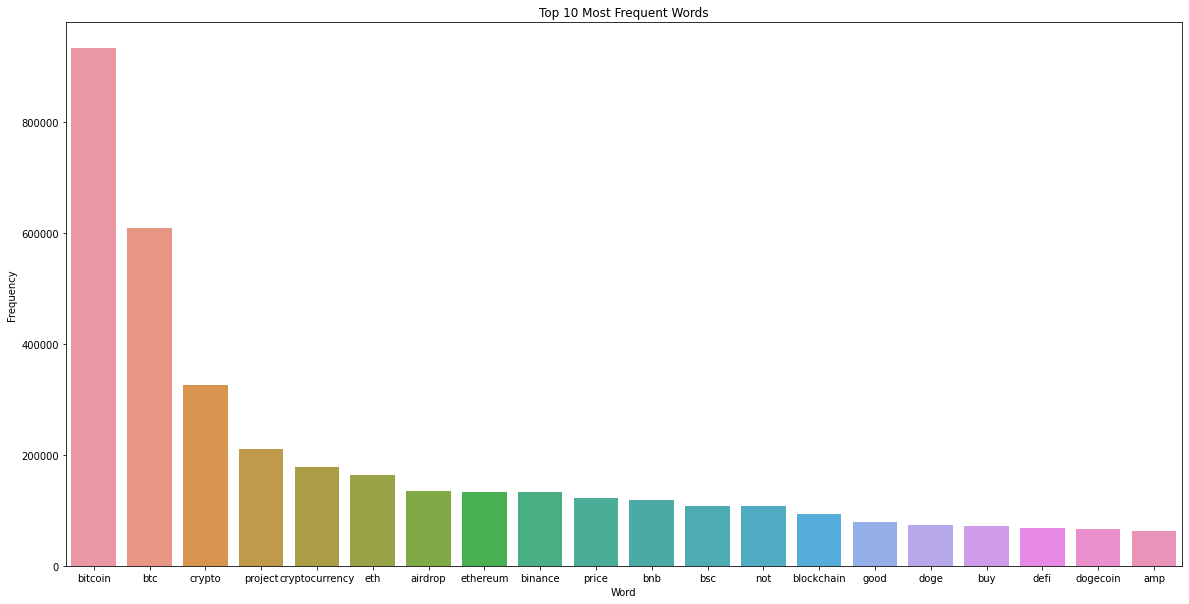

In [ ]:

plt.figure(figsize=(20,10))
axis = sns.barplot(data=df_freq_words, x='Word', y='Frequency')
axis.set(ylabel='Frequency')
plt.title('Top 10 Most Frequent Words')
plt.show()

In [ ]:
import ast

def list_formatter(x):
  if x == '':
    return []
  elif type(x) != str:
    return []
  else:
    return ast.literal_eval(x)

In [ ]:
hashtags = list(map(list_formatter, df_tweets['hashtags'].values))


In [ ]:
type(df_tweets['hashtags'][2])

str

In [ ]:
from collections import Counter

flat_list = [item for sublist in hashtags for item in sublist]


In [ ]:
for i in range(len(flat_list)):
   flat_list[i] = flat_list[i].lower()



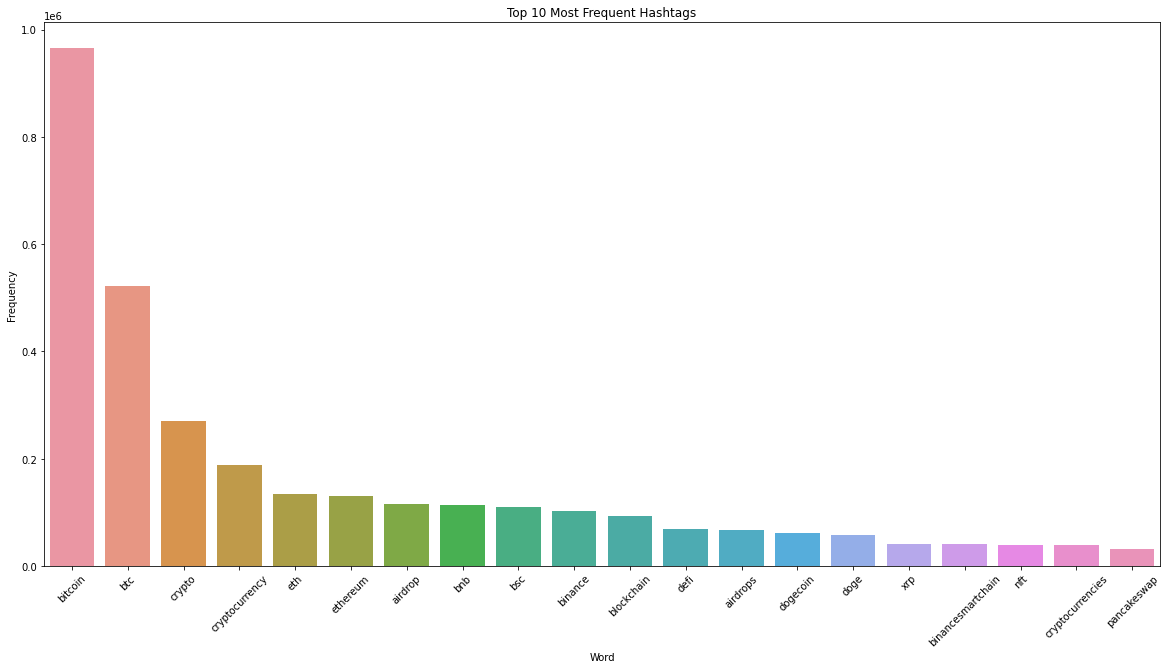

In [ ]:
d = Counter(" ".join(flat_list).split()).most_common(20)
df_freq_hashtags = pd.DataFrame(d, columns=['Word', 'Frequency'])

plt.figure(figsize=(20,10))
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']  
axis = sns.barplot(data=df_freq_hashtags, x='Word', y='Frequency')
axis.set(ylabel='Frequency')
plt.xticks(rotation = 45)

plt.title('Top 10 Most Frequent Hashtags')
plt.show()

In [ ]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score > 0:
        return 'Positive'
    else:
        return 'Neutral'

df_tweets['Analysis_Polarity'] = df_tweets['Polarity'].apply(getAnalysis)




In [ ]:
df_tweets.sample(10)
df_textblob = pd.get_dummies(df_tweets['Analysis_Polarity'])
df_textblob['datetime'] = df_tweets['datetime']
df_textblob['lemm_text'] = df_tweets['lemm_text']
df_textblob

Negative  ...                                          lemm_text
0               0  ...  [blue, ridge, bank, shares, halted, nyse, bitc...
1               0  ...  [today, thursday, take, friend, leowandersleb,...
2               0  ...   [guys, evening, read, article, btc, would, like]
3               0  ...  [btc, big, chance, billion, price, 4872644, 20...
4               1  ...  [network, secured, 508, nodes, today, soon, bi...
...           ...  ...                                                ...
1232804         0  ...  [speedupbsc, debi, pada, adatiers, golf, grind...
1232805         1  ...  [time, happen, coinbase, btc, eth, coinbase, sec]
1232806         0  ...                                    [one, btc, 205]
1232807         0  ...  [want, join, group, posted, tsla, 745p, day, t...
1232808         0  ...  [cabanacrypto, live, cabanacrypto, hex, happy,...

[1232803 rows x 5 columns]

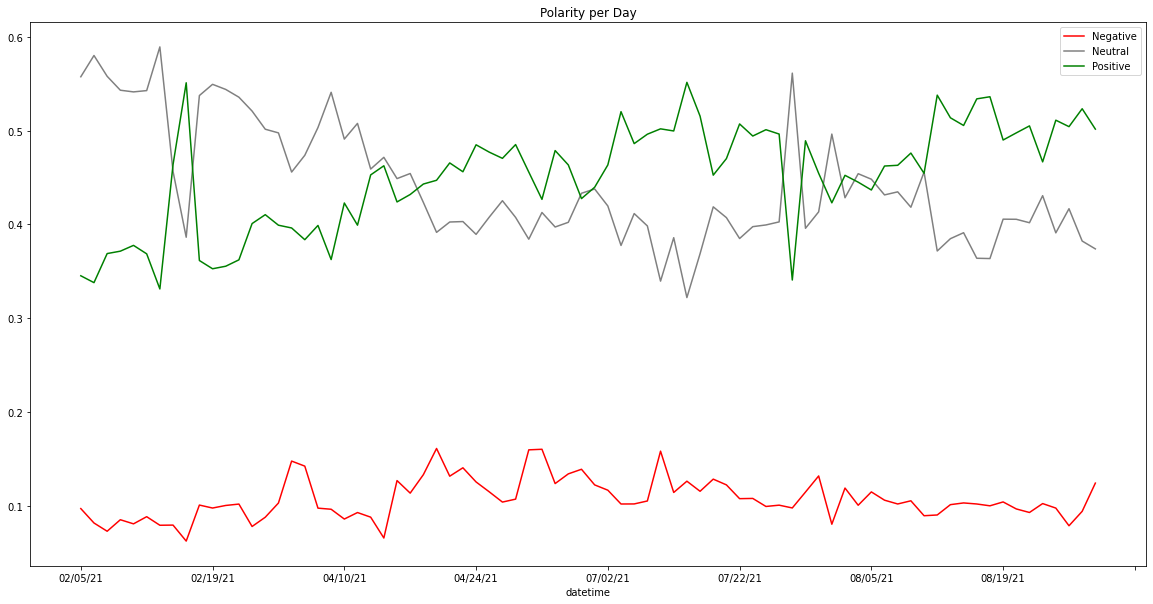

In [ ]:

df_textblob['datetime'] = pd.to_datetime(df_textblob['datetime'], errors = 'coerce')
df_textblob.sort_values(by = 'datetime')

df_textblob['datetime'] = df_textblob['datetime'].dt.strftime('%D')
x = df_textblob[['datetime', 'Negative', 'Neutral', 'Positive']]
y = x.set_index('datetime')
z = y.groupby('datetime').mean()

z.plot.line(stacked=False, title='Polarity per Day', figsize=(20,10), color={"Negative": "red", "Neutral": "grey", "Positive": "green"})

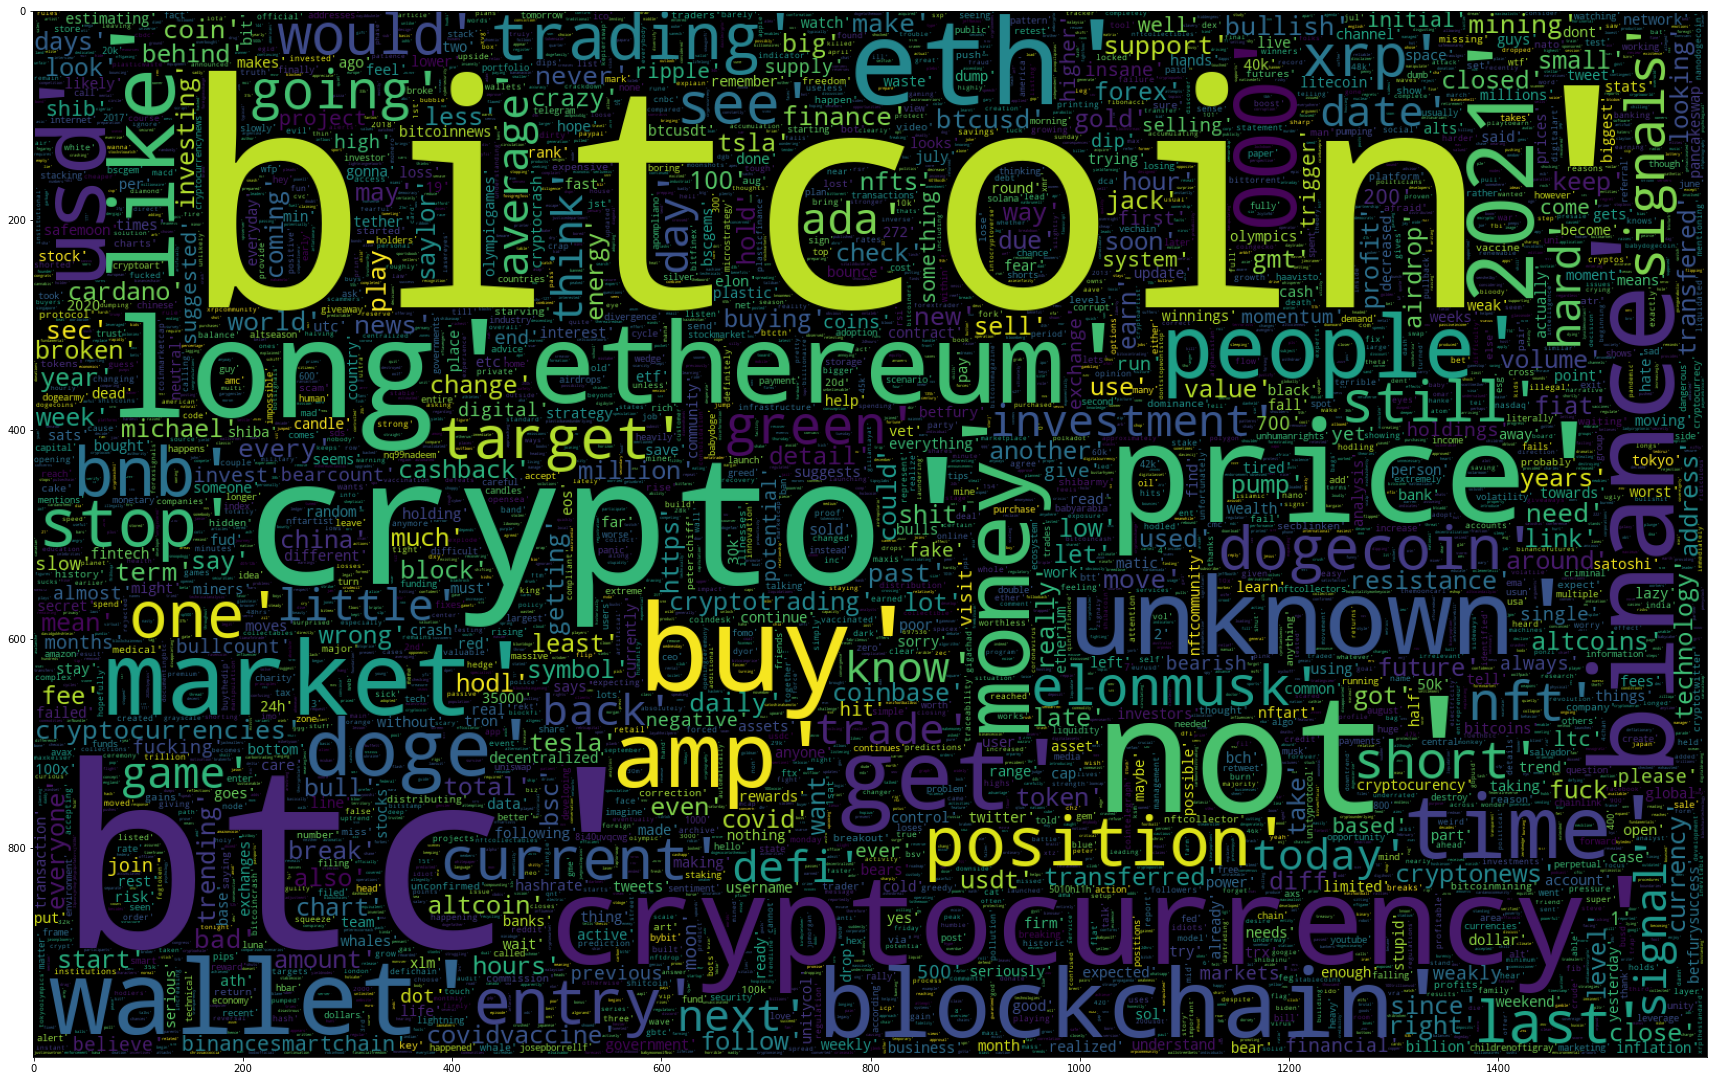

In [ ]:
#plot a cloud for negative tweets

data_neg = df_tweets.loc[df_tweets['Analysis_Polarity'] == 'Negative']
plt.figure(figsize = (30, 30))
wc = WordCloud(max_words = 6000 , width = 1600 , height = 1000,
               collocations=False).generate(" ".join(str(v) for v in data_neg['lemm_text']))
plt.imshow(wc)

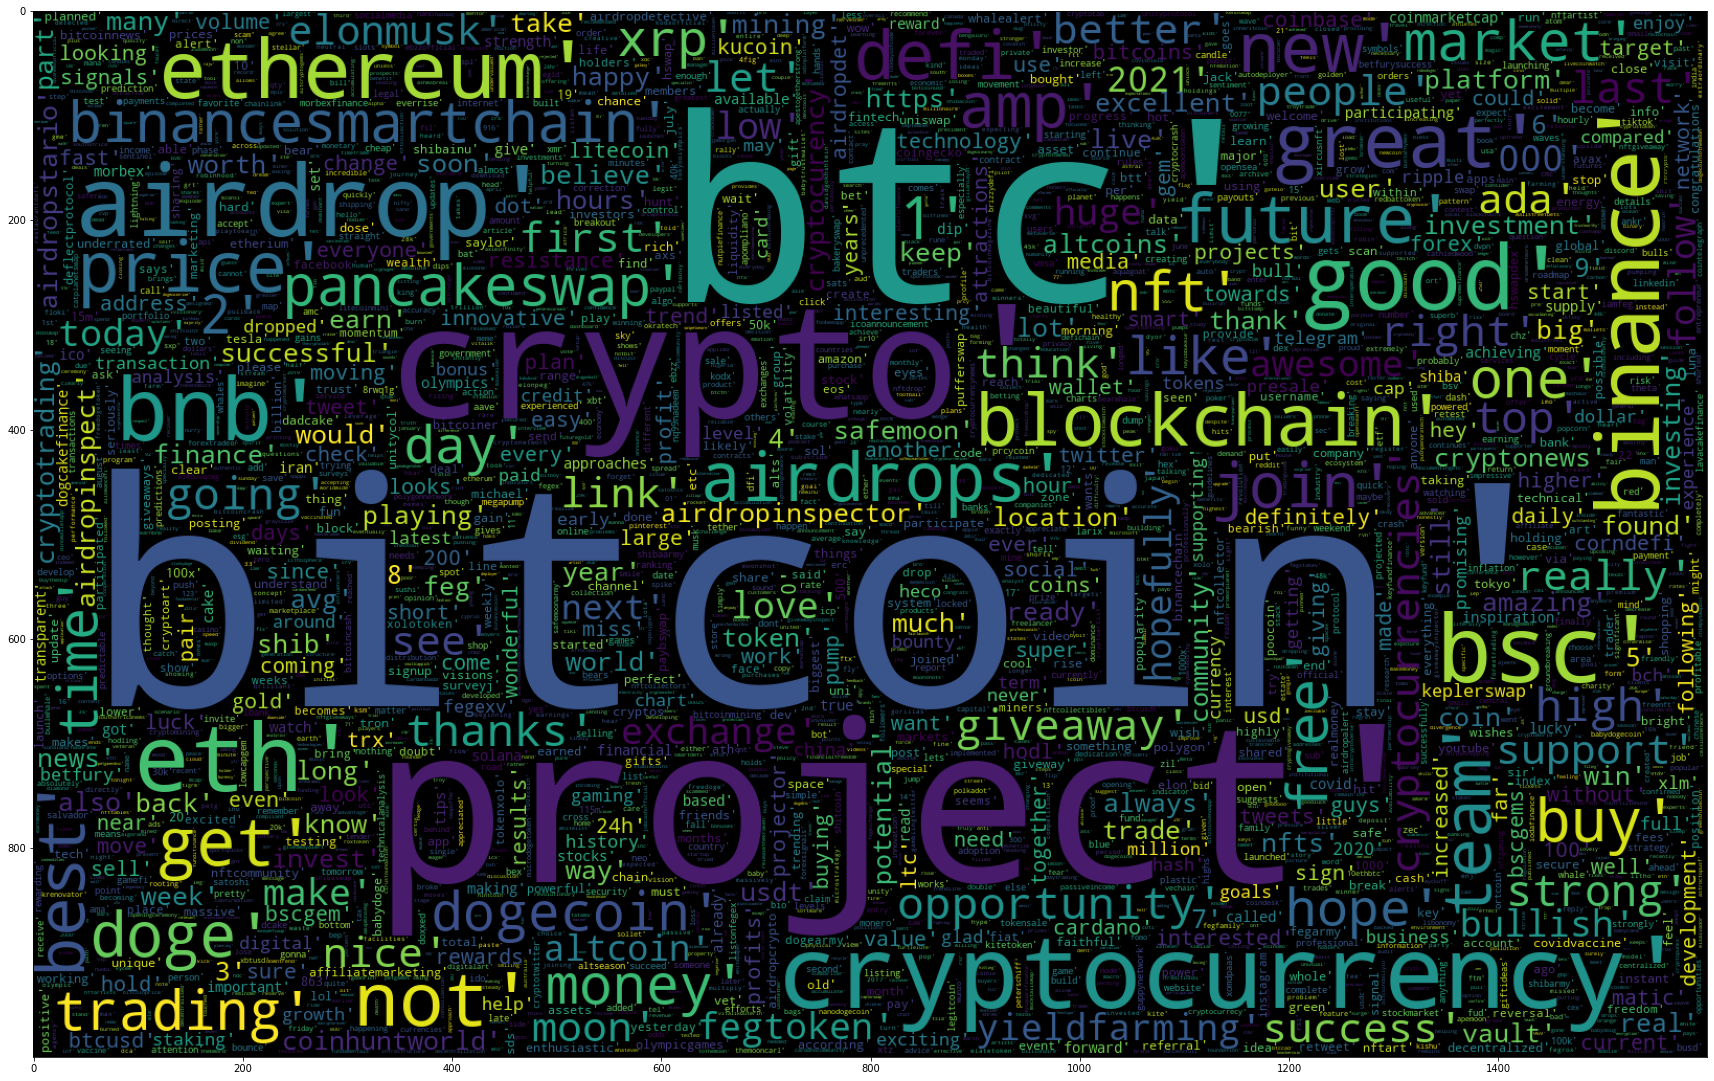

In [ ]:
#plot a cloud for positive tweets
data_pos = df_textblob.loc[df_textblob['Positive'] == 1]
plt.figure(figsize = (30,30))
wc = WordCloud(max_words = 8000 , width = 1600 , height = 1000,
               collocations=False).generate(" ".join(str(v) for v in data_pos['lemm_text']))
plt.imshow(wc)

In [ ]:
df_tweets.describe()


user_followers      Polarity  ...  Neutral_vader  Positive_vader
count    1.232799e+06  1.232803e+06  ...   1.232797e+06    1.232797e+06
mean     9.126677e+03  1.492660e-01  ...   7.922377e-01    1.638511e-01
std      1.207023e+05  2.720815e-01  ...   1.893258e-01    1.769023e-01
min      0.000000e+00 -1.000000e+00  ...   0.000000e+00    0.000000e+00
25%      4.300000e+01  0.000000e+00  ...   6.580000e-01    0.000000e+00
50%      2.200000e+02  0.000000e+00  ...   8.080000e-01    1.270000e-01
75%      1.430000e+03  3.000000e-01  ...   1.000000e+00    2.800000e-01
max      2.359728e+07  1.000000e+00  ...   1.000000e+00    1.000000e+00

[8 rows x 6 columns]

In [ ]:
print('Printing a few positive tweets:\n')
j=1
sortedDF = df_tweets.sort_values(by=['Polarity']) #Sort the tweets
for i in range(0, 100 ):
    if( sortedDF['Analysis_Polarity'][i] == 'Positive'):
        print(str(j) + ') '+ sortedDF['text'][i])
        print()
        j= j+1

Printing a few positive tweets:

1) trade crypto binance enjoy cashback trading fee sign

2) annnd btc bitcoin headed even higher

3) join first virtual crypto meetup 2021 crypto fridays something everyone whether

4) forget know cryptocurrency coins listed nasdaq etf real ones

5) btc bitcoin ethereum eth crypto cryptotrading eth next determine local top

6) three precious gems reached ath today link dot grt powerhouses

7) free mailey advice imagine 2019 bitcoin mining company mined 20000 btc qtrly held

8) want learn forex trading join great team forex forexsignals trading forextrader forextrade

9) ask every bitcoin whale chance would give 100 bitcoin 100 positive would

10) market btc aud last price 58798 hour high 61550 hour low 57009 best bid 58655 best ask 58798 btc

11) christmas came early restore token airdrop live next generation passive issuance

12) nikon invest friends early 2017 like mate better burn money instead buying bitcoin scam sam

13) bitcoin amzn wmt others abl

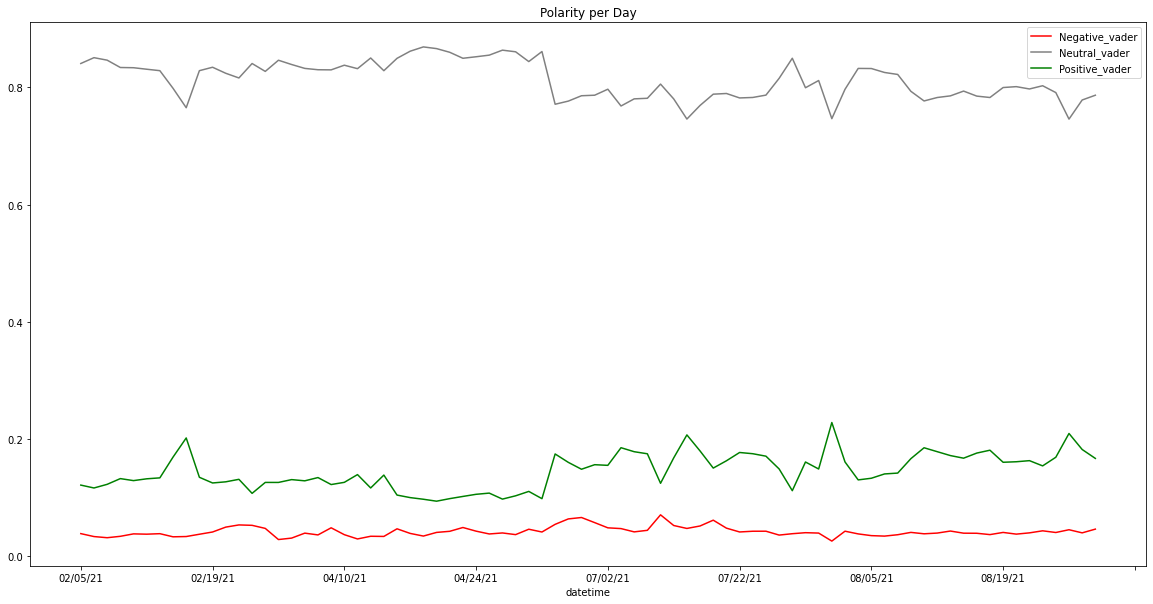

In [ ]:

df_tweets['datetime'] = pd.to_datetime(df_tweets['datetime'], errors = 'coerce')
df_tweets.sort_values(by = 'datetime')

df_tweets['datetime'] = df_tweets['datetime'].dt.strftime('%D')
x = df_tweets[['datetime', 'Negative_vader', 'Neutral_vader', 'Positive_vader']]
y = x.set_index('datetime')
z = y.groupby('datetime').mean()

z.plot.line(stacked=False, title='Polarity per Day', figsize=(20,10), color={"Negative_vader": "red", "Neutral_vader": "grey", "Positive_vader": "green"})

In [ ]:
import datetime as dt
df_groupby = df_tweets[['date','text']].copy()
df_groupby['date'] = pd.to_datetime(df_tweets['datetime'], errors = 'coerce').dt.strftime('%Y-%m-%d')
df_groupby.groupby(['date']).agg('count')


text
date             
2021-02-05   1694
2021-02-06   3278
2021-02-07   3030
2021-02-08   5646
2021-02-09   4350
...           ...
2021-08-23  10502
2021-08-24  26905
2021-08-25  47042
2021-08-26  39166
2021-09-10  23511

[78 rows x 1 columns]

In [ ]:
df_groupby['count'] 


0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
1232798   NaN
1232799   NaN
1232800   NaN
1232801   NaN
1232802   NaN
Name: count, Length: 1232803, dtype: float64

In [ ]:
# df_tweets['datetime'] = pd.to_datetime(df_tweets['datetime'], errors = 'coerce')
ax = df_groupby.plot.bar(x='date', y='text')
# z.plot.bar(stacked=False, title='Daily Tweets volume', figsize=(20,10), color={"Negative_vader": "red", "Neutral_vader": "grey", "Positive_vader": "green"})

TypeError: ignored

In [ ]:
df_tweets['datetime'] = pd.to_datetime(df_tweets['datetime'], errors = 'coerce')

filtered_columns = ["datetime","score"]
d_raw = df_tweets.reindex(columns = filtered_columns)
d_daily = d_raw.groupby(pd.Grouper(key='datetime',freq='D')).agg('count')



In [ ]:
df_for_model = df_tweets[['text']]

NameError: ignored

In [ ]:
df_tweets.to_csv('/content/drive/MyDrive/is417-project/data_for_modeling.csv')

In [ ]:
df_for_model

text
0        blue ridge bank shares halted nyse bitcoin atm...
1        today thursday take friend leowandersleb btc w...
2           guys evening read article btc would like share
3        btc big chance billion price 4872644 2021 bitc...
4        network secured 508 nodes today soon biggest b...
...                                                    ...
1232804  speedupbsc debi pada adatiers golf grinder fir...
1232805      time happen sec coinbase btc eth coinbase sec
1232806                                   one btc 205 egld
1232807  want join group posted tsla 745p day trade wen...
1232808  cabanacrypto live cabanacrypto hex happy hour ...

[1232803 rows x 1 columns]

In [ ]:
import pandas as pd
df_tweets = pd.read_csv('/content/drive/MyDrive/is417-project/data_for_modeling.csv',engine='python',encoding='utf-8', error_bad_lines=False, dtype='str')
df_tweets


Unnamed: 0  ... Analysis_Polarity
0                0  ...           Neutral
1                1  ...           Neutral
2                2  ...           Neutral
3                3  ...           Neutral
4                4  ...          Negative
...            ...  ...               ...
1232798    1232804  ...           Neutral
1232799    1232805  ...          Negative
1232800    1232806  ...           Neutral
1232801    1232807  ...          Positive
1232802    1232808  ...          Positive

[1232803 rows x 24 columns]

In [ ]:
import swifter
from collections import Counter

d = Counter(" ".join(df_tweets["hashtags"]).split()).most_common(20)
df_hashtags = pd.DataFrame(d, columns=['Hashtags', 'Frequency'])

df_hashtags




AttributeError: ignored

In [ ]:

plt.figure(figsize=(30,20))
axis = sns.barplot(data=df_freq_words, x='Word', y='Frequency')
axis.set(ylabel='Frequency')
plt.title('Top 10 Most Frequent Hashtags')
plt.show()

In [ ]:
import pandas as pd
df_tweets = pd.read_csv('/content/drive/MyDrive/is417-project/data_for_modeling.csv',engine='python',encoding='utf-8', error_bad_lines=False, dtype='str')
df_tweets


Unnamed: 0  ... Analysis_Polarity
0                0  ...           Neutral
1                1  ...           Neutral
2                2  ...           Neutral
3                3  ...           Neutral
4                4  ...          Negative
...            ...  ...               ...
1232798    1232804  ...           Neutral
1232799    1232805  ...          Negative
1232800    1232806  ...           Neutral
1232801    1232807  ...          Positive
1232802    1232808  ...          Positive

[1232803 rows x 24 columns]

In [ ]:
df_tweets['Analysis_Polarity'].value_counts()

Positive    593287
Neutral     504676
Negative    134840
Name: Analysis_Polarity, dtype: int64

In [ ]:
df_positive = df_tweets[df_tweets['Analysis_Polarity']=="Positive"].copy()
df_positive = df_positive.sample(134840).copy().reset_index()

df_positive.drop(['index', 'Unnamed: 0'], axis=1, inplace=True)


In [ ]:
df_neutral = df_tweets[df_tweets['Analysis_Polarity']=="Neutral"].copy()
df_neutral = df_neutral.sample(134840).copy().reset_index()

df_neutral.drop(['index', 'Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df_negative = df_tweets[df_tweets['Analysis_Polarity']=="Negative"].copy()
df_negative.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df_tweets = pd.concat([df_neutral, df_negative, df_positive])

In [ ]:
df_tweets['Analysis_Polarity'].value_counts()

Positive    134840
Negative    134840
Neutral     134840
Name: Analysis_Polarity, dtype: int64

In [ ]:
# df_tweets = df_tweets.sample(frac=0.5, replace = True).copy()
# df_tweets = df_tweets.reset_index()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
df_for_model = df_tweets['text'].astype(str)

In [ ]:
#BoW text
count_vect = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=7500) #in scikit-learn
data3 = df_for_model.values
data3 = np.nan_to_num(data3)

In [ ]:
count_vect_text = count_vect.fit_transform(data3)

In [ ]:
count_vect_text.get_shape()

(404520, 7500)

In [ ]:
df_modified = df_tweets[["user_followers","user_friends", "user_favourites","Polarity","Compound_vader","Negative_vader","Neutral_vader","Positive_vader"]].to_numpy()

In [ ]:
#BoW user_verified
count_vect = CountVectorizer() #in scikit-learn
data2 = df_tweets['user_verified'].astype(str).values.ravel()
data2 = np.nan_to_num(data2)
count_vect_user_verified = count_vect.fit_transform(data2)

In [ ]:
#BoW text source
count_vect = CountVectorizer() #in scikit-learn
data1 = df_tweets['source'].astype(str).values.ravel()
data1 = np.nan_to_num(data1)
count_vect_source = count_vect.fit_transform(data1)

In [ ]:
from scipy.sparse import hstack

In [ ]:
X_bow = hstack((count_vect_source, count_vect_user_verified, count_vect_text)).tocsr()

In [ ]:
df_modified = df_modified.astype(float)
df_modified[np.isnan(df_modified)] = 0

X_bow = hstack((X_bow, df_modified))

In [ ]:
y_bow = df_tweets['Analysis_Polarity']
y_bow.value_counts()

Positive    134840
Negative    134840
Neutral     134840
Name: Analysis_Polarity, dtype: int64

In [ ]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [ ]:
mapper = dict(zip(y_bow.unique(), [0,1,2]))
mapper

{'Negative': 1, 'Neutral': 0, 'Positive': 2}

In [ ]:
y_bow = df_tweets['Analysis_Polarity'].map(mapper)

In [ ]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
 
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_bow, y_bow, random_state = 0, test_size = 0.3)
 
# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, dtree_predictions)

In [ ]:
cm

array([[40539,     0,     0],
       [   36, 40482,     0],
       [   13,     0, 40286]])

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['Neutral','Negative','Positive'], 
                     columns = ['Neutral','Negative','Positive'])
cm_df

Neutral  Negative  Positive
Neutral     40539         0         0
Negative       36     40482         0
Positive       27         0     40272

Text(0.5, 1.0, 'Confusion Matrix')

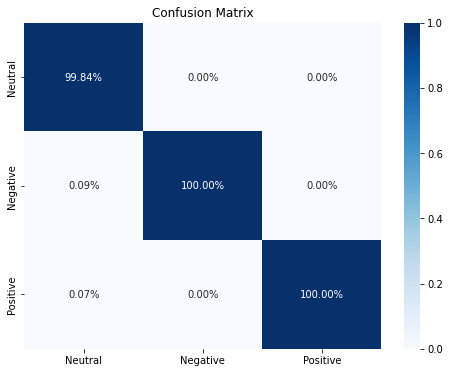

In [ ]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))  
sns.heatmap(cm_df/np.sum(cm_df), annot=True, 
            fmt='.2%', cmap='Blues', ax=ax)
plt.title('Confusion Matrix')

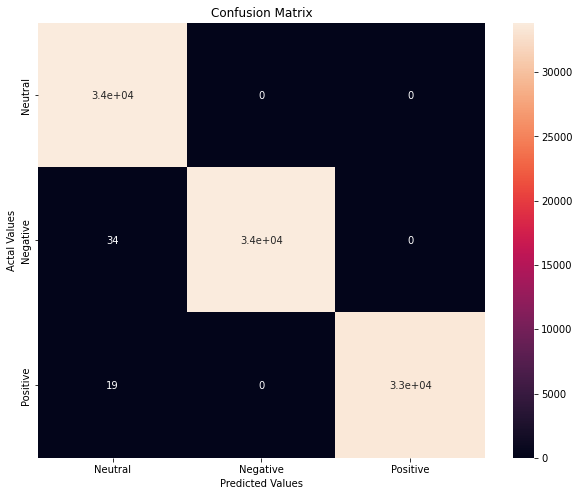

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
import pandas as pd
df_tweets = pd.read_csv('/content/drive/MyDrive/is417-project/data_for_modeling.csv',engine='python',encoding='utf-8', error_bad_lines=False, dtype='str')
df_tweets

Unnamed: 0  ... Analysis_Polarity
0                0  ...           Neutral
1                1  ...           Neutral
2                2  ...           Neutral
3                3  ...           Neutral
4                4  ...          Negative
...            ...  ...               ...
1232798    1232804  ...           Neutral
1232799    1232805  ...          Negative
1232800    1232806  ...           Neutral
1232801    1232807  ...          Positive
1232802    1232808  ...          Positive

[1232803 rows x 24 columns]

In [ ]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:

x_train,x_test,y_train,y_test = train_test_split(df_tweets['lemm_text'],df_tweets['Analysis_Polarity'],test_size = 0.3)

In [ ]:
y_bow = df_tweets['Analysis_Polarity']
mapper = dict(zip(y_bow.unique(), [0,1,2]))
y_bow = df_tweets['Analysis_Polarity'].map(mapper)
y_bow

0         0
1         0
2         0
3         0
4         0
         ..
134835    2
134836    2
134837    2
134838    2
134839    2
Name: Analysis_Polarity, Length: 404520, dtype: int64

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# train_bow = CountVectorizer().fit(x_train)
# x_train_matrix = train_bow.transform(x_train)
# tf_id_train = TfidfTransformer().fit(x_train_matrix)
# tf_train_matrix = tf_id_train.transform(x_train_matrix)

In [ ]:
# test_bow = train_bow.transform(x_test)
# test_tf = tf_id_train.transform(test_bow)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report,accuracy_score,f1_score
# rfc = RandomForestClassifier(n_estimators=200)
# rfc.fit(tf_train_matrix,y_train)
# y_pred_rfc = rfc.predict(test_tf)
# print(classification_report(y_test,y_pred_rfc))
# accuracy = round(accuracy_score(y_test,y_pred_rfc) * 100,2)
# print("Accuracy score is "+str(accuracy)+'%')

In [ ]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_bow, y_bow, random_state = 0)

# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)

# creating a confusion matrix
knn_predictions = knn.predict(X_test)
cm = confusion_matrix(y_test, knn_predictions)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['Neutral','Negative','Positive'], 
                     columns = ['Neutral','Negative','Positive'])
cm_df

Neutral  Negative  Positive
Neutral     20786      7593      5388
Negative    10884     17982      4987
Positive     9438      7164     16908

Text(0.5, 1.0, 'Confusion Matrix')

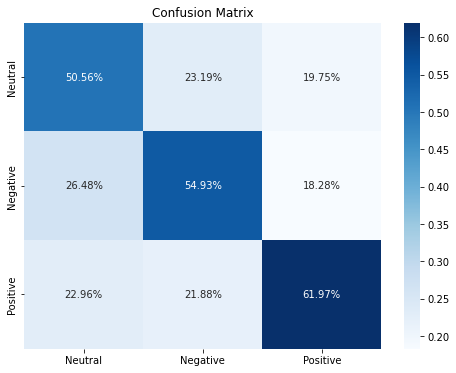

In [ ]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))  
sns.heatmap(cm_df/np.sum(cm_df), annot=True, 
            fmt='.2%', cmap='Blues', ax=ax)
plt.title('Confusion Matrix')

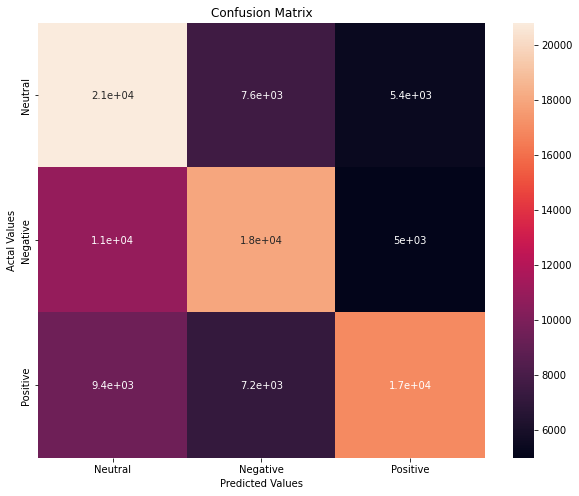

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
 
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_bow, y_bow, random_state = 0, test_size = 0.3)
 
# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, dtree_predictions)